## Apply correction to S1 granules in V2

In [1]:
# Auto-reload all modules to pick up latest edits to dependent modules
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

# Enable output of all statements in the cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import logging
# Set up logging
logging.basicConfig(
    level = logging.INFO,
    format = '%(asctime)s - %(levelname)s - %(message)s',
    datefmt = '%Y-%m-%d %H:%M:%S'
)

from datetime import datetime
import pandas as pd
import s3fs
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import subprocess
import rioxarray as rxr

from itscube_types import DataVars, Coords, Output
from mission_info import Encoding

2023-06-22 16:26:29 - INFO - Note: NumExpr detected 10 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2023-06-22 16:26:29 - INFO - NumExpr defaulting to 8 threads.


### Read Joe's parquet file with granule info

In [2]:
table = pd.read_parquet('../tools/fix_s1_v2_granules/correction_table/sentinel-1-correction-files.parquet')
table

,reference,secondary,v2_s3_bucket,v2_s3_key,status,to_correct,cor_s3_bucket,job_id
0,S1A_IW_SLC__1SDV_20170203T162106_20170203T1621...,S1A_IW_SLC__1SDV_20170215T162105_20170215T1621...,its-live-data,velocity_image_pair/sentinel1/v02/N00E020/S1A_...,SUCCEEDED,False,hyp3-its-live-contentbucket-s10lg85g5sp4,a851f0b5-9ae2-43fe-b81d-344eeae67b79
1,S1A_IW_SLC__1SDV_20170203T162106_20170203T1621...,S1A_IW_SLC__1SDV_20170215T162105_20170215T1621...,its-live-data,velocity_image_pair/sentinel1/v02/N00E020/S1A_...,SUCCEEDED,False,hyp3-its-live-contentbucket-s10lg85g5sp4,a851f0b5-9ae2-43fe-b81d-344eeae67b79
2,S1A_IW_SLC__1SDV_20170203T162106_20170203T1621...,S1A_IW_SLC__1SDV_20170215T162105_20170215T1621...,its-live-data,velocity_image_pair/sentinel1/v02/N00E020/S1A_...,SUCCEEDED,False,hyp3-its-live-contentbucket-s10lg85g5sp4,a851f0b5-9ae2-43fe-b81d-344eeae67b79
3,S1A_IW_SLC__1SDV_20170215T162105_20170215T1621...,S1A_IW_SLC__1SDV_20170227T162105_20170227T1621...,its-live-data,velocity_image_pair/sentinel1/v02/N00E020/S1A_...,SUCCEEDED,False,hyp3-its-live-contentbucket-s10lg85g5sp4,9028f920-195b-4f0b-84c8-74e2f7d467ed
4,S1A_IW_SLC__1SDV_20170215T162105_20170215T1621...,S1A_IW_SLC__1SDV_20170227T162105_20170227T1621...,its-live-data,velocity_image_pair/sentinel1/v02/N00E020/S1A_...,SUCCEEDED,False,hyp3-its-live-contentbucket-s10lg85g5sp4,9028f920-195b-4f0b-84c8-74e2f7d467ed
...,...,...,...,...,...,...,...,...
1469632,S1A_IW_SLC__1SSH_20150606T120529_20150606T1205...,S1A_IW_SLC__1SSH_20150618T120529_20150618T1205...,its-live-data,velocity_image_pair/sentinel1/v02/S70W170/S1A_...,SUCCEEDED,False,hyp3-its-live-contentbucket-s10lg85g5sp4,ffe00c4c-088d-4702-b201-847acd726629
1469633,S1A_IW_SLC__1SSH_20150606T120529_20150606T1205...,S1A_IW_SLC__1SSH_20150618T120529_20150618T1205...,its-live-data,velocity_image_pair/sentinel1/v02/S70W170/S1A_...,SUCCEEDED,False,hyp3-its-live-contentbucket-s10lg85g5sp4,ffe00c4c-088d-4702-b201-847acd726629
1469634,S1A_IW_SLC__1SSH_20150618T120529_20150618T1205...,S1A_IW_SLC__1SSH_20150630T120530_20150630T1205...,its-live-data,velocity_image_pair/sentinel1/v02/S70W170/S1A_...,SUCCEEDED,False,hyp3-its-live-contentbucket-s10lg85g5sp4,65e1188f-47d6-486e-9c37-1d14246d1efa
1469635,S1A_IW_SLC__1SSH_20150618T120529_20150618T1205...,S1A_IW_SLC__1SSH_20150630T120530_20150630T1205...,its-live-data,velocity_image_pair/sentinel1/v02/S70W170/S1A_...,SUCCEEDED,False,hyp3-its-live-contentbucket-s10lg85g5sp4,65e1188f-47d6-486e-9c37-1d14246d1efa


In [4]:
# Select rows with to_correct=True only
sel_table = table.loc[table['to_correct'] == True]
sel_table

,reference,secondary,v2_s3_bucket,v2_s3_key,status,to_correct,cor_s3_bucket,job_id
357237,S1A_IW_SLC__1SDV_20141217T060358_20141217T0604...,S1A_IW_SLC__1SDV_20141229T060357_20141229T0604...,its-live-data,velocity_image_pair/sentinel1/v02/N50E000/S1A_...,SUCCEEDED,True,hyp3-its-live-contentbucket-s10lg85g5sp4,17c7668e-4104-4d67-8768-ce07d92405a2
357240,S1A_IW_SLC__1SDV_20141229T060357_20141229T0604...,S1A_IW_SLC__1SDV_20150110T060357_20150110T0604...,its-live-data,velocity_image_pair/sentinel1/v02/N50E000/S1A_...,SUCCEEDED,True,hyp3-its-live-contentbucket-s10lg85g5sp4,51499493-5341-424e-aff7-e57ed92fd529
357243,S1A_IW_SLC__1SDV_20150110T060357_20150110T0604...,S1A_IW_SLC__1SDV_20150122T060356_20150122T0604...,its-live-data,velocity_image_pair/sentinel1/v02/N50E000/S1A_...,SUCCEEDED,True,hyp3-its-live-contentbucket-s10lg85g5sp4,157658ec-7676-4c5b-805d-1c8b85dd948e
357246,S1A_IW_SLC__1SDV_20150122T060356_20150122T0604...,S1A_IW_SLC__1SDV_20150203T060356_20150203T0604...,its-live-data,velocity_image_pair/sentinel1/v02/N50E000/S1A_...,SUCCEEDED,True,hyp3-its-live-contentbucket-s10lg85g5sp4,074d08f3-c831-4126-8cb4-e869aa70d1ea
357249,S1A_IW_SLC__1SDV_20150124T170201_20150124T1702...,S1A_IW_SLC__1SDV_20150205T170201_20150205T1702...,its-live-data,velocity_image_pair/sentinel1/v02/N50E000/S1A_...,SUCCEEDED,True,hyp3-its-live-contentbucket-s10lg85g5sp4,776f9599-760d-4a9b-ac6d-c3e126317573
...,...,...,...,...,...,...,...,...
1239123,S1B_IW_SLC__1SSH_20211203T082529_20211203T0825...,S1B_IW_SLC__1SSH_20211215T082529_20211215T0825...,its-live-data,velocity_image_pair/sentinel1/v02/S60W060/S1B_...,SUCCEEDED,True,hyp3-its-live-contentbucket-s10lg85g5sp4,ce258583-dcc5-42b5-9be1-4813ec87176c
1239126,S1B_IW_SLC__1SSH_20211203T082557_20211203T0826...,S1A_IW_SLC__1SSH_20211209T082638_20211209T0827...,its-live-data,velocity_image_pair/sentinel1/v02/S60W060/S1B_...,SUCCEEDED,True,hyp3-its-live-contentbucket-s10lg85g5sp4,a0148726-41ce-4fae-9016-b43afb32ebfa
1239129,S1B_IW_SLC__1SSH_20211203T082557_20211203T0826...,S1B_IW_SLC__1SSH_20211215T082556_20211215T0826...,its-live-data,velocity_image_pair/sentinel1/v02/S60W060/S1B_...,SUCCEEDED,True,hyp3-its-live-contentbucket-s10lg85g5sp4,a0148726-41ce-4fae-9016-b43afb32ebfa
1239171,S1B_IW_SLC__1SSH_20211215T082529_20211215T0825...,S1A_IW_SLC__1SSH_20211221T082610_20211221T0826...,its-live-data,velocity_image_pair/sentinel1/v02/S60W060/S1B_...,SUCCEEDED,True,hyp3-its-live-contentbucket-s10lg85g5sp4,9030f1db-9b19-4bb9-94d6-edd0161209a6


## Fix V2 S1 granules using region reference GeoTiffs which are fixed at 1 day dt

ATTN: No need to scale up the raster values by granule's dt as originally thought and suggested

In [2]:
NoDataValue = -32767

def float_to_int(data, nan_mask):
    """
    Replace Nan's with NoDataValue before converting data to np.int16 to avoid Nan->0 replacement
    """
    masked_data = np.where(nan_mask, NoDataValue, data)
    int_data = np.round(np.clip(masked_data, -32768, 32767)).astype(np.int16)
    
    return int_data

In [3]:
def correct(granule_path: str, tif_dir: str, output_path: str, s3 = None):
    """
    Apply S1 data correction to provided granule.
    
    Inputs:
    =======
    granule_path: Path to the granule to correct
    tif_dif: Directory with reference TIF files as generated by autoRIFT
    output_path: Directory path to store corrected granule to.
    s3: s3fs.S3FileSystem object if input granule to correct is stored in AWS S3 bucket. Default is None
        meaning to use locally stored granule.
    """
    NC_ENGINE = 'h5netcdf'
    
    # Reference TIF files required for correction
    vx_tiff_file = 'window_rdr_off2vel_x_vec.tif'
    vy_tiff_file = 'window_rdr_off2vel_y_vec.tif'
    window_tiff_file = 'window_scale_factor.tif'

    print(f'Correcting {granule_path}')
    # Read bands from TIF files
    vx_tiff = None
    with rxr.open_rasterio(os.path.join(tif_dir, vx_tiff_file), mask_and_scale=True) as vx_tiff:
        pass

    vy_tiff = None
    with rxr.open_rasterio(os.path.join(tif_dir, vy_tiff_file), mask_and_scale=True) as vy_tiff:
        pass

    window_tiff = None
    with rxr.open_rasterio(os.path.join(tif_dir, window_tiff_file), mask_and_scale=True) as window_tiff:
        pass

    # Read granule to correct
    ds = None
    if s3 is not None:
        # Granule is in S3 bucket
        with s3.open(granule_path, mode='rb') as fhandle:
            with xr.open_dataset(fhandle, engine=NC_ENGINE) as ds:
                ds = ds.load()
    else:
        with xr.open_dataset(granule_path) as ds:
            pass
    
    # Crop TIFs to granule's X/Y ranges
    mask_x = (vx_tiff.x >= ds.x.min().item()) & (vx_tiff.x <= ds.x.max().item())
    mask_y = (vx_tiff.y >= ds.y.min().item()) & (vx_tiff.y <= ds.y.max().item())
    mask = (mask_x & mask_y)
    
    cropped_vx_tiff = vx_tiff.where(mask, drop=True)
    cropped_vy_tiff = vy_tiff.where(mask, drop=True)
    cropped_window_tiff = window_tiff.where(mask, drop=True)
    
    # Get parameters from TIFs
    AA = cropped_vx_tiff[0]
    BB = cropped_vx_tiff[1]
    di_to_vr_factor = cropped_vx_tiff[2].values

    CC = cropped_vy_tiff[0]
    DD = cropped_vy_tiff[1]
    dj_to_va_factor = cropped_vy_tiff[2].values
    
    scalefactor_di = cropped_window_tiff[0].values  # ai
    scalefactor_dj = cropped_window_tiff[1].values  # aj
    
    dr_to_vr_factor = ds.M11.attrs['dr_to_vr_factor']
    
    di = ds.vr.values / dr_to_vr_factor
    dj = ds.va.values / dj_to_va_factor

    # Compute new vx and vy
    vx = AA * di * scalefactor_di + BB * dj * scalefactor_dj
    vy = CC * di * scalefactor_di + DD * dj * scalefactor_dj
    
    v = np.sqrt(vx**2 + vy**2)
    
    # Compute new M matrix (M1* elements)
    M11 = DD / (AA * DD - BB * CC)/ scalefactor_di
    M12 = DD / (AA * DD - BB * CC)/ scalefactor_di
    
    # Compute new va
    va = ds.va.values / scalefactor_dj
    
    # Convert corrected data to int when storing to the file
    nan_mask = np.isnan(vx) | np.isnan(vy)
    
    # Update granule to include corrected data
    ds['vx'] = xr.DataArray(
        data=float_to_int(vx, nan_mask),
        coords=ds.vx.coords,
        dims=ds.vx.dims,
        attrs=ds.vx.attrs
    )

    ds['vy'] = xr.DataArray(
        data=float_to_int(vy, nan_mask),
        coords=ds.vy.coords,
        dims=ds.vy.dims,
        attrs=ds.vy.attrs
    )

    ds['v'] = xr.DataArray(
        data=float_to_int(v, nan_mask),
        coords=ds.v.coords,
        dims=ds.v.dims,
        attrs=ds.v.attrs
    )

    ds['va'] = xr.DataArray(
        data=float_to_int(va, nan_mask),
        coords=ds.va.coords,
        dims=ds.va.dims,
        attrs=ds.va.attrs
    )

    ds['M11'] = xr.DataArray(
        data=float_to_int(M11, nan_mask),
        coords=ds.M11.coords,
        dims=ds.M11.dims,
        attrs=ds.M11.attrs
    )

    ds['M12'] = xr.DataArray(
        data=float_to_int(M12, nan_mask),
        coords=ds.M12.coords,
        dims=ds.M12.dims,
        attrs=ds.M12.attrs
    )
    
    # Set the date when the granule was updated
    ds.attrs['date_updated'] = datetime.now().strftime('%d-%b-%Y %H:%M:%S')
    
    # Set chunking for 2D data variables
    dims = ds.dims
    num_x = dims[Coords.X]
    num_y = dims[Coords.Y]

    # Compute chunking like AutoRIFT does:
    # https://github.com/ASFHyP3/hyp3-autorift/blob/develop/hyp3_autorift/vend/netcdf_output.py#L410-L411
    chunk_lines = np.min([np.ceil(8192/num_y)*128, num_y])
    two_dim_chunks_settings = (chunk_lines, num_x)

    granule_encoding = Encoding.SENTINEL1.copy()

    for each_var, each_var_settings in granule_encoding.items():
        if each_var_settings[Output.FILL_VALUE_ATTR] is not None:
            each_var_settings[Output.CHUNKSIZES_ATTR] = two_dim_chunks_settings
    
    fixed_file = os.path.join(output_path, os.path.basename(granule_path))
    print(f'Writing corrected granule to {fixed_file}')
    ds.to_netcdf(fixed_file, engine='h5netcdf', encoding=granule_encoding)
    

### Correct some granules

In [28]:
tif_dir_path = '../tools/fix_s1_v2_granules/test_tiffs'
corrected_dir_path = 'corrected_S1_for_validation'
granules_to_correct = [
  '../tools/fix_s1_v2_granules/test_region_granules_validation_intermediate/S1A_IW_SLC__1SDH_20170710T154532_20170710T154559_017411_01D160_D5EE_X_S1B_IW_SLC__1SDH_20170716T154439_20170716T154506_006515_00B749_AC95_G0120V02_P046.nc'
]

for each_granule in granules_to_correct:
    correct(each_granule, tif_dir=tif_dir_path, output_path=corrected_dir_path)

Correcting ../tools/fix_s1_v2_granules/test_region_granules_validation_intermediate/S1A_IW_SLC__1SDH_20170710T154532_20170710T154559_017411_01D160_D5EE_X_S1B_IW_SLC__1SDH_20170716T154439_20170716T154506_006515_00B749_AC95_G0120V02_P046.nc


2023-06-21 13:57:25 - WARNING - CPLE_AppDefined in PROJ: proj_create_from_database: /opt/homebrew/Caskroom/miniforge/base/envs/itslivecube/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
2023-06-21 13:57:25 - WARNING - CPLE_AppDefined in The definition of projected CRS EPSG:3413 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.
2023-06-21 13:57:25 - WARNING - CPLE_AppDefined in PROJ: proj_create_from_database: /opt/homebrew/Caskroom/miniforge/base/envs/itslivecube/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
2023-06-21 13:57:25 - WARNING 

Writing corrected granule to corrected_S1_for_validation/S1A_IW_SLC__1SDH_20170710T154532_20170710T154559_017411_01D160_D5EE_X_S1B_IW_SLC__1SDH_20170716T154439_20170716T154506_006515_00B749_AC95_G0120V02_P046.nc


In [6]:
validation_granules = [
    's3://hyp3-its-live-contentbucket-s10lg85g5sp4/b0a53824-6b5c-4efc-a3cc-0b45876a4849/S1A_IW_SLC__1SDH_20170710T154532_20170710T154559_017411_01D160_D5EE_X_S1B_IW_SLC__1SDH_20170716T154439_20170716T154506_006515_00B749_AC95_G0120V02_P046.nc',
    's3://hyp3-its-live-contentbucket-s10lg85g5sp4/ac004e1e-0c1a-4346-b2b1-4f446b14e2d2/S1A_IW_SLC__1SDH_20170710T154532_20170710T154559_017411_01D160_D5EE_X_S1B_IW_SLC__1SDH_20170716T154504_20170716T154528_006515_00B749_AD2F_G0120V02_P051.nc',
    's3://hyp3-its-live-contentbucket-s10lg85g5sp4/416c9cb7-a5e9-4b92-a6b2-66e453582a48/S1A_IW_SLC__1SDH_20170710T154532_20170710T154559_017411_01D160_D5EE_X_S1A_IW_SLC__1SDH_20170722T154533_20170722T154600_017586_01D6B3_87B3_G0120V02_P044.nc',
    's3://hyp3-its-live-contentbucket-s10lg85g5sp4/1c32e0d1-86ae-4fe3-880f-1359d40ba930/S1A_IW_SLC__1SDH_20170710T154532_20170710T154559_017411_01D160_D5EE_X_S1B_IW_SLC__1SDH_20170728T154440_20170728T154507_006690_00BC44_5663_G0120V02_P042.nc',
    's3://hyp3-its-live-contentbucket-s10lg85g5sp4/9e25a499-dd29-4066-ad09-4780b4eb5984/S1A_IW_SLC__1SDH_20170710T154532_20170710T154559_017411_01D160_D5EE_X_S1B_IW_SLC__1SDH_20170728T154505_20170728T154528_006690_00BC44_F187_G0120V02_P045.nc',
    's3://hyp3-its-live-contentbucket-s10lg85g5sp4/e6dd0efa-296e-4718-9d8e-83aa025e0576/S1A_IW_SLC__1SDH_20170710T154532_20170710T154559_017411_01D160_D5EE_X_S1B_IW_SLC__1SDH_20170809T154441_20170809T154508_006865_00C155_4348_G0120V02_P041.nc',
    's3://hyp3-its-live-contentbucket-s10lg85g5sp4/c5ecc65e-03a0-4a1b-a4c5-2e09e3d0c87d/S1A_IW_SLC__1SDH_20170710T154532_20170710T154559_017411_01D160_D5EE_X_S1B_IW_SLC__1SDH_20170809T154505_20170809T154529_006865_00C155_3B08_G0120V02_P043.nc',
    's3://hyp3-its-live-contentbucket-s10lg85g5sp4/3c9f052a-8f31-4f19-90d9-572905ec851a/S1A_IW_SLC__1SDH_20170710T154532_20170710T154559_017411_01D160_D5EE_X_S1B_IW_SLC__1SDH_20170821T154441_20170821T154508_007040_00C66C_CD72_G0120V02_P039.nc',
    's3://hyp3-its-live-contentbucket-s10lg85g5sp4/3c895e90-07f1-48cd-8966-89be7da99461/S1A_IW_SLC__1SDH_20170710T154532_20170710T154559_017411_01D160_D5EE_X_S1A_IW_SLC__1SDH_20170827T154535_20170827T154601_018111_01E6AB_ABC7_G0120V02_P038.nc',
    's3://hyp3-its-live-contentbucket-s10lg85g5sp4/c51019de-286c-45ca-8ad6-e73cafc466c5/S1A_IW_SLC__1SDH_20170710T154532_20170710T154559_017411_01D160_D5EE_X_S1B_IW_SLC__1SDH_20170902T154442_20170902T154509_007215_00CB7D_1016_G0120V02_P036.nc',
    's3://hyp3-its-live-contentbucket-s10lg85g5sp4/40f462bd-e2c8-4519-b6cf-d1453e74f4ef/S1A_IW_SLC__1SDH_20170710T154532_20170710T154559_017411_01D160_D5EE_X_S1B_IW_SLC__1SDH_20170902T154506_20170902T154530_007215_00CB7D_2BEC_G0120V02_P041.nc',
    's3://hyp3-its-live-contentbucket-s10lg85g5sp4/43153091-36d7-412b-9f1f-6fc965b132e6/S1A_IW_SLC__1SDH_20170710T154532_20170710T154559_017411_01D160_D5EE_X_S1A_IW_SLC__1SDH_20170908T154535_20170908T154602_018286_01EC02_C4FE_G0120V02_P039.nc'
]

### Copy validation granules from Joe's bucket to ITS_LIVE bucket

In [11]:
import boto3

SOURCE_BUCKET = 'hyp3-its-live-contentbucket-s10lg85g5sp4'
BUCKET = 'its-live-data'
BUCKET_DIR = 'test_datacubes/s1_correction/correctedByJoe'

bucket = boto3.resource('s3').Bucket(BUCKET)

for each_granule in validation_granules:
    target_key = os.path.join(BUCKET_DIR, os.path.basename(each_granule))

    print(f'Copy {each_granule} to {target_key}')
    
    source_key = each_granule.replace('s3://hyp3-its-live-contentbucket-s10lg85g5sp4/', '')
    source_dict = {
        'Bucket': SOURCE_BUCKET,
        'Key': source_key
    }

    bucket.copy(source_dict, target_key)

    # !aws s3 ls each_granule

Copy s3://hyp3-its-live-contentbucket-s10lg85g5sp4/b0a53824-6b5c-4efc-a3cc-0b45876a4849/S1A_IW_SLC__1SDH_20170710T154532_20170710T154559_017411_01D160_D5EE_X_S1B_IW_SLC__1SDH_20170716T154439_20170716T154506_006515_00B749_AC95_G0120V02_P046.nc to test_datacubes/s1_correction/correctedByJoe/S1A_IW_SLC__1SDH_20170710T154532_20170710T154559_017411_01D160_D5EE_X_S1B_IW_SLC__1SDH_20170716T154439_20170716T154506_006515_00B749_AC95_G0120V02_P046.nc
Copy s3://hyp3-its-live-contentbucket-s10lg85g5sp4/ac004e1e-0c1a-4346-b2b1-4f446b14e2d2/S1A_IW_SLC__1SDH_20170710T154532_20170710T154559_017411_01D160_D5EE_X_S1B_IW_SLC__1SDH_20170716T154504_20170716T154528_006515_00B749_AD2F_G0120V02_P051.nc to test_datacubes/s1_correction/correctedByJoe/S1A_IW_SLC__1SDH_20170710T154532_20170710T154559_017411_01D160_D5EE_X_S1B_IW_SLC__1SDH_20170716T154504_20170716T154528_006515_00B749_AD2F_G0120V02_P051.nc
Copy s3://hyp3-its-live-contentbucket-s10lg85g5sp4/416c9cb7-a5e9-4b92-a6b2-66e453582a48/S1A_IW_SLC__1SDH_20170

In [4]:
granules = [
    'velocity_image_pair/sentinel1/v02/N70E010/S1A_IW_SLC__1SDH_20170710T154532_20170710T154559_017411_01D160_D5EE_X_S1B_IW_SLC__1SDH_20170716T154439_20170716T154506_006515_00B749_AC95_G0120V02_P046.nc',
    'velocity_image_pair/sentinel1/v02/N70E010/S1A_IW_SLC__1SDH_20170710T154532_20170710T154559_017411_01D160_D5EE_X_S1B_IW_SLC__1SDH_20170716T154504_20170716T154528_006515_00B749_AD2F_G0120V02_P051.nc',
    'velocity_image_pair/sentinel1/v02/N70E010/S1A_IW_SLC__1SDH_20170710T154532_20170710T154559_017411_01D160_D5EE_X_S1A_IW_SLC__1SDH_20170722T154533_20170722T154600_017586_01D6B3_87B3_G0120V02_P044.nc',
    'velocity_image_pair/sentinel1/v02/N70E010/S1A_IW_SLC__1SDH_20170710T154532_20170710T154559_017411_01D160_D5EE_X_S1B_IW_SLC__1SDH_20170728T154440_20170728T154507_006690_00BC44_5663_G0120V02_P042.nc',
    'velocity_image_pair/sentinel1/v02/N70E010/S1A_IW_SLC__1SDH_20170710T154532_20170710T154559_017411_01D160_D5EE_X_S1B_IW_SLC__1SDH_20170728T154505_20170728T154528_006690_00BC44_F187_G0120V02_P045.nc',
    'velocity_image_pair/sentinel1/v02/N70E010/S1A_IW_SLC__1SDH_20170710T154532_20170710T154559_017411_01D160_D5EE_X_S1B_IW_SLC__1SDH_20170809T154441_20170809T154508_006865_00C155_4348_G0120V02_P041.nc',
    'velocity_image_pair/sentinel1/v02/N70E010/S1A_IW_SLC__1SDH_20170710T154532_20170710T154559_017411_01D160_D5EE_X_S1B_IW_SLC__1SDH_20170809T154505_20170809T154529_006865_00C155_3B08_G0120V02_P043.nc',
    'velocity_image_pair/sentinel1/v02/N70E010/S1A_IW_SLC__1SDH_20170710T154532_20170710T154559_017411_01D160_D5EE_X_S1B_IW_SLC__1SDH_20170821T154441_20170821T154508_007040_00C66C_CD72_G0120V02_P039.nc',
    'velocity_image_pair/sentinel1/v02/N70E010/S1A_IW_SLC__1SDH_20170710T154532_20170710T154559_017411_01D160_D5EE_X_S1A_IW_SLC__1SDH_20170827T154535_20170827T154601_018111_01E6AB_ABC7_G0120V02_P038.nc',
    'velocity_image_pair/sentinel1/v02/N70E010/S1A_IW_SLC__1SDH_20170710T154532_20170710T154559_017411_01D160_D5EE_X_S1B_IW_SLC__1SDH_20170902T154442_20170902T154509_007215_00CB7D_1016_G0120V02_P036.nc',
    'velocity_image_pair/sentinel1/v02/N70E010/S1A_IW_SLC__1SDH_20170710T154532_20170710T154559_017411_01D160_D5EE_X_S1B_IW_SLC__1SDH_20170902T154506_20170902T154530_007215_00CB7D_2BEC_G0120V02_P041.nc',
    'velocity_image_pair/sentinel1/v02/N70E010/S1A_IW_SLC__1SDH_20170710T154532_20170710T154559_017411_01D160_D5EE_X_S1A_IW_SLC__1SDH_20170908T154535_20170908T154602_018286_01EC02_C4FE_G0120V02_P039.nc'
]

In [5]:
tif_dir_path = '../tools/fix_s1_v2_granules/test_tiffs'
corrected_dir_path = 'corrected_S1_for_validation'

s3_obj = s3fs.S3FileSystem(anon=True, skip_instance_cache=True)

for each_granule in granules:
    each_granule_path = os.path.join('s3://its-live-data', each_granule)
    
    correct(each_granule_path, tif_dir=tif_dir_path, output_path=corrected_dir_path, s3=s3_obj)

2023-06-21 17:52:17 - WARNING - CPLE_AppDefined in PROJ: proj_create_from_database: /opt/homebrew/Caskroom/miniforge/base/envs/itslivecube/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
2023-06-21 17:52:17 - WARNING - CPLE_AppDefined in The definition of projected CRS EPSG:3413 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.
2023-06-21 17:52:17 - WARNING - CPLE_AppDefined in PROJ: proj_create_from_database: /opt/homebrew/Caskroom/miniforge/base/envs/itslivecube/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
2023-06-21 17:52:17 - WARNING 

Correcting s3://its-live-data/velocity_image_pair/sentinel1/v02/N70E010/S1A_IW_SLC__1SDH_20170710T154532_20170710T154559_017411_01D160_D5EE_X_S1B_IW_SLC__1SDH_20170716T154439_20170716T154506_006515_00B749_AC95_G0120V02_P046.nc


2023-06-21 17:52:17 - WARNING - CPLE_AppDefined in PROJ: proj_create_from_database: /opt/homebrew/Caskroom/miniforge/base/envs/itslivecube/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
2023-06-21 17:52:17 - WARNING - CPLE_AppDefined in The definition of projected CRS EPSG:3413 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.
2023-06-21 17:52:19 - WARNING - CPLE_AppDefined in PROJ: proj_create_from_database: /opt/homebrew/Caskroom/miniforge/base/envs/itslivecube/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
2023-06-21 17:52:19 - WARNING 

Writing corrected granule to corrected_S1_for_validation/S1A_IW_SLC__1SDH_20170710T154532_20170710T154559_017411_01D160_D5EE_X_S1B_IW_SLC__1SDH_20170716T154439_20170716T154506_006515_00B749_AC95_G0120V02_P046.nc
Correcting s3://its-live-data/velocity_image_pair/sentinel1/v02/N70E010/S1A_IW_SLC__1SDH_20170710T154532_20170710T154559_017411_01D160_D5EE_X_S1B_IW_SLC__1SDH_20170716T154504_20170716T154528_006515_00B749_AD2F_G0120V02_P051.nc


2023-06-21 17:52:22 - WARNING - CPLE_AppDefined in PROJ: proj_create_from_database: /opt/homebrew/Caskroom/miniforge/base/envs/itslivecube/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
2023-06-21 17:52:22 - WARNING - CPLE_AppDefined in The definition of projected CRS EPSG:3413 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.
2023-06-21 17:52:22 - WARNING - CPLE_AppDefined in PROJ: proj_create_from_database: /opt/homebrew/Caskroom/miniforge/base/envs/itslivecube/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
2023-06-21 17:52:22 - WARNING 

Writing corrected granule to corrected_S1_for_validation/S1A_IW_SLC__1SDH_20170710T154532_20170710T154559_017411_01D160_D5EE_X_S1B_IW_SLC__1SDH_20170716T154504_20170716T154528_006515_00B749_AD2F_G0120V02_P051.nc
Correcting s3://its-live-data/velocity_image_pair/sentinel1/v02/N70E010/S1A_IW_SLC__1SDH_20170710T154532_20170710T154559_017411_01D160_D5EE_X_S1A_IW_SLC__1SDH_20170722T154533_20170722T154600_017586_01D6B3_87B3_G0120V02_P044.nc


2023-06-21 17:52:24 - WARNING - CPLE_AppDefined in PROJ: proj_create_from_database: /opt/homebrew/Caskroom/miniforge/base/envs/itslivecube/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
2023-06-21 17:52:24 - WARNING - CPLE_AppDefined in The definition of projected CRS EPSG:3413 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.
2023-06-21 17:52:25 - WARNING - CPLE_AppDefined in PROJ: proj_create_from_database: /opt/homebrew/Caskroom/miniforge/base/envs/itslivecube/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
2023-06-21 17:52:25 - WARNING 

Writing corrected granule to corrected_S1_for_validation/S1A_IW_SLC__1SDH_20170710T154532_20170710T154559_017411_01D160_D5EE_X_S1A_IW_SLC__1SDH_20170722T154533_20170722T154600_017586_01D6B3_87B3_G0120V02_P044.nc
Correcting s3://its-live-data/velocity_image_pair/sentinel1/v02/N70E010/S1A_IW_SLC__1SDH_20170710T154532_20170710T154559_017411_01D160_D5EE_X_S1B_IW_SLC__1SDH_20170728T154440_20170728T154507_006690_00BC44_5663_G0120V02_P042.nc


2023-06-21 17:52:27 - WARNING - CPLE_AppDefined in PROJ: proj_create_from_database: /opt/homebrew/Caskroom/miniforge/base/envs/itslivecube/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
2023-06-21 17:52:27 - WARNING - CPLE_AppDefined in The definition of projected CRS EPSG:3413 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.
2023-06-21 17:52:27 - WARNING - CPLE_AppDefined in PROJ: proj_create_from_database: /opt/homebrew/Caskroom/miniforge/base/envs/itslivecube/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
2023-06-21 17:52:27 - WARNING 

Writing corrected granule to corrected_S1_for_validation/S1A_IW_SLC__1SDH_20170710T154532_20170710T154559_017411_01D160_D5EE_X_S1B_IW_SLC__1SDH_20170728T154440_20170728T154507_006690_00BC44_5663_G0120V02_P042.nc
Correcting s3://its-live-data/velocity_image_pair/sentinel1/v02/N70E010/S1A_IW_SLC__1SDH_20170710T154532_20170710T154559_017411_01D160_D5EE_X_S1B_IW_SLC__1SDH_20170728T154505_20170728T154528_006690_00BC44_F187_G0120V02_P045.nc


2023-06-21 17:52:29 - WARNING - CPLE_AppDefined in PROJ: proj_create_from_database: /opt/homebrew/Caskroom/miniforge/base/envs/itslivecube/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
2023-06-21 17:52:29 - WARNING - CPLE_AppDefined in The definition of projected CRS EPSG:3413 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.
2023-06-21 17:52:29 - WARNING - CPLE_AppDefined in PROJ: proj_create_from_database: /opt/homebrew/Caskroom/miniforge/base/envs/itslivecube/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
2023-06-21 17:52:29 - WARNING 

Writing corrected granule to corrected_S1_for_validation/S1A_IW_SLC__1SDH_20170710T154532_20170710T154559_017411_01D160_D5EE_X_S1B_IW_SLC__1SDH_20170728T154505_20170728T154528_006690_00BC44_F187_G0120V02_P045.nc
Correcting s3://its-live-data/velocity_image_pair/sentinel1/v02/N70E010/S1A_IW_SLC__1SDH_20170710T154532_20170710T154559_017411_01D160_D5EE_X_S1B_IW_SLC__1SDH_20170809T154441_20170809T154508_006865_00C155_4348_G0120V02_P041.nc


2023-06-21 17:52:31 - WARNING - CPLE_AppDefined in PROJ: proj_create_from_database: /opt/homebrew/Caskroom/miniforge/base/envs/itslivecube/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
2023-06-21 17:52:31 - WARNING - CPLE_AppDefined in The definition of projected CRS EPSG:3413 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.
2023-06-21 17:52:31 - WARNING - CPLE_AppDefined in PROJ: proj_create_from_database: /opt/homebrew/Caskroom/miniforge/base/envs/itslivecube/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
2023-06-21 17:52:31 - WARNING 

Writing corrected granule to corrected_S1_for_validation/S1A_IW_SLC__1SDH_20170710T154532_20170710T154559_017411_01D160_D5EE_X_S1B_IW_SLC__1SDH_20170809T154441_20170809T154508_006865_00C155_4348_G0120V02_P041.nc
Correcting s3://its-live-data/velocity_image_pair/sentinel1/v02/N70E010/S1A_IW_SLC__1SDH_20170710T154532_20170710T154559_017411_01D160_D5EE_X_S1B_IW_SLC__1SDH_20170809T154505_20170809T154529_006865_00C155_3B08_G0120V02_P043.nc


2023-06-21 17:52:33 - WARNING - CPLE_AppDefined in PROJ: proj_create_from_database: /opt/homebrew/Caskroom/miniforge/base/envs/itslivecube/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
2023-06-21 17:52:33 - WARNING - CPLE_AppDefined in The definition of projected CRS EPSG:3413 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.
2023-06-21 17:52:33 - WARNING - CPLE_AppDefined in PROJ: proj_create_from_database: /opt/homebrew/Caskroom/miniforge/base/envs/itslivecube/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
2023-06-21 17:52:33 - WARNING 

Writing corrected granule to corrected_S1_for_validation/S1A_IW_SLC__1SDH_20170710T154532_20170710T154559_017411_01D160_D5EE_X_S1B_IW_SLC__1SDH_20170809T154505_20170809T154529_006865_00C155_3B08_G0120V02_P043.nc
Correcting s3://its-live-data/velocity_image_pair/sentinel1/v02/N70E010/S1A_IW_SLC__1SDH_20170710T154532_20170710T154559_017411_01D160_D5EE_X_S1B_IW_SLC__1SDH_20170821T154441_20170821T154508_007040_00C66C_CD72_G0120V02_P039.nc


2023-06-21 17:52:35 - WARNING - CPLE_AppDefined in PROJ: proj_create_from_database: /opt/homebrew/Caskroom/miniforge/base/envs/itslivecube/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
2023-06-21 17:52:35 - WARNING - CPLE_AppDefined in The definition of projected CRS EPSG:3413 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.
2023-06-21 17:52:36 - WARNING - CPLE_AppDefined in PROJ: proj_create_from_database: /opt/homebrew/Caskroom/miniforge/base/envs/itslivecube/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
2023-06-21 17:52:36 - WARNING 

Writing corrected granule to corrected_S1_for_validation/S1A_IW_SLC__1SDH_20170710T154532_20170710T154559_017411_01D160_D5EE_X_S1B_IW_SLC__1SDH_20170821T154441_20170821T154508_007040_00C66C_CD72_G0120V02_P039.nc
Correcting s3://its-live-data/velocity_image_pair/sentinel1/v02/N70E010/S1A_IW_SLC__1SDH_20170710T154532_20170710T154559_017411_01D160_D5EE_X_S1A_IW_SLC__1SDH_20170827T154535_20170827T154601_018111_01E6AB_ABC7_G0120V02_P038.nc


2023-06-21 17:52:38 - WARNING - CPLE_AppDefined in PROJ: proj_create_from_database: /opt/homebrew/Caskroom/miniforge/base/envs/itslivecube/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
2023-06-21 17:52:38 - WARNING - CPLE_AppDefined in The definition of projected CRS EPSG:3413 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.
2023-06-21 17:52:38 - WARNING - CPLE_AppDefined in PROJ: proj_create_from_database: /opt/homebrew/Caskroom/miniforge/base/envs/itslivecube/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
2023-06-21 17:52:38 - WARNING 

Writing corrected granule to corrected_S1_for_validation/S1A_IW_SLC__1SDH_20170710T154532_20170710T154559_017411_01D160_D5EE_X_S1A_IW_SLC__1SDH_20170827T154535_20170827T154601_018111_01E6AB_ABC7_G0120V02_P038.nc
Correcting s3://its-live-data/velocity_image_pair/sentinel1/v02/N70E010/S1A_IW_SLC__1SDH_20170710T154532_20170710T154559_017411_01D160_D5EE_X_S1B_IW_SLC__1SDH_20170902T154442_20170902T154509_007215_00CB7D_1016_G0120V02_P036.nc


2023-06-21 17:52:41 - WARNING - CPLE_AppDefined in PROJ: proj_create_from_database: /opt/homebrew/Caskroom/miniforge/base/envs/itslivecube/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
2023-06-21 17:52:41 - WARNING - CPLE_AppDefined in The definition of projected CRS EPSG:3413 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.
2023-06-21 17:52:41 - WARNING - CPLE_AppDefined in PROJ: proj_create_from_database: /opt/homebrew/Caskroom/miniforge/base/envs/itslivecube/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
2023-06-21 17:52:41 - WARNING 

Writing corrected granule to corrected_S1_for_validation/S1A_IW_SLC__1SDH_20170710T154532_20170710T154559_017411_01D160_D5EE_X_S1B_IW_SLC__1SDH_20170902T154442_20170902T154509_007215_00CB7D_1016_G0120V02_P036.nc
Correcting s3://its-live-data/velocity_image_pair/sentinel1/v02/N70E010/S1A_IW_SLC__1SDH_20170710T154532_20170710T154559_017411_01D160_D5EE_X_S1B_IW_SLC__1SDH_20170902T154506_20170902T154530_007215_00CB7D_2BEC_G0120V02_P041.nc


2023-06-21 17:52:43 - WARNING - CPLE_AppDefined in PROJ: proj_create_from_database: /opt/homebrew/Caskroom/miniforge/base/envs/itslivecube/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
2023-06-21 17:52:43 - WARNING - CPLE_AppDefined in The definition of projected CRS EPSG:3413 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.
2023-06-21 17:52:43 - WARNING - CPLE_AppDefined in PROJ: proj_create_from_database: /opt/homebrew/Caskroom/miniforge/base/envs/itslivecube/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
2023-06-21 17:52:43 - WARNING 

Writing corrected granule to corrected_S1_for_validation/S1A_IW_SLC__1SDH_20170710T154532_20170710T154559_017411_01D160_D5EE_X_S1B_IW_SLC__1SDH_20170902T154506_20170902T154530_007215_00CB7D_2BEC_G0120V02_P041.nc
Correcting s3://its-live-data/velocity_image_pair/sentinel1/v02/N70E010/S1A_IW_SLC__1SDH_20170710T154532_20170710T154559_017411_01D160_D5EE_X_S1A_IW_SLC__1SDH_20170908T154535_20170908T154602_018286_01EC02_C4FE_G0120V02_P039.nc


2023-06-21 17:52:45 - WARNING - CPLE_AppDefined in PROJ: proj_create_from_database: /opt/homebrew/Caskroom/miniforge/base/envs/itslivecube/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
2023-06-21 17:52:45 - WARNING - CPLE_AppDefined in The definition of projected CRS EPSG:3413 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.
2023-06-21 17:52:45 - WARNING - CPLE_AppDefined in PROJ: proj_create_from_database: /opt/homebrew/Caskroom/miniforge/base/envs/itslivecube/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
2023-06-21 17:52:45 - WARNING 

Writing corrected granule to corrected_S1_for_validation/S1A_IW_SLC__1SDH_20170710T154532_20170710T154559_017411_01D160_D5EE_X_S1A_IW_SLC__1SDH_20170908T154535_20170908T154602_018286_01EC02_C4FE_G0120V02_P039.nc


### Plot M differences: validation granule vs. corrected granule

In [15]:
# validate_granule_path = '../tools/fix_s1_v2_granules/test_tiffs/S1A_IW_SLC__1SDH_20170710T154532_20170710T154559_017411_01D160_D5EE_X_S1B_IW_SLC__1SDH_20170716T154439_20170716T154506_006515_00B749_AC95_G0120V02_P046.nc'
validate_granule_path = '../tools/fix_s1_v2_granules/test_region_granules_validation_intermediate/S1A_IW_SLC__1SDH_20170710T154532_20170710T154559_017411_01D160_D5EE_X_S1B_IW_SLC__1SDH_20170716T154439_20170716T154506_006515_00B749_AC95_G0120V02_P046.nc'

validate_ds = None
with xr.open_dataset(validate_granule_path) as validate_ds:
    validate_ds
    
# validate_ds.vx.plot(x='x', y='y')
# plt.suptitle('Corrected VX')

vx_validate = validate_ds.vx.values
np.nanmin(vx_validate), np.nanmax(vx_validate)

<xarray.Dataset>
Dimensions:           (x: 1204, y: 2205)
Coordinates:
  * x                 (x) float64 9.561e+05 9.562e+05 ... 1.1e+06 1.1e+06
  * y                 (y) float64 -4.712e+05 -4.713e+05 ... -7.357e+05
Data variables: (12/13)
    img_pair_info     object ...
    mapping           object ...
    vx                (y, x) float32 ...
    vy                (y, x) float32 ...
    v                 (y, x) float32 ...
    v_error           (y, x) float32 ...
    ...                ...
    va                (y, x) float32 ...
    M11               (y, x) float32 ...
    M12               (y, x) float32 ...
    chip_size_width   (y, x) float32 ...
    chip_size_height  (y, x) float32 ...
    interp_mask       (y, x) float32 ...
Attributes: (12/14)
    GDAL_AREA_OR_POINT:         Area
    Conventions:                CF-1.8
    date_created:               05-Jun-2023 22:07:41
    title:                      autoRIFT surface velocities
    autoRIFT_software_version:  1.5.0
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    ...                         ...
    motion_detection_method:    feature
    motion_coordinates:         radar, map
    author:                     Alex S. Gardner, JPL/NASA; Yang Lei, GPS/Caltech
    institution:                NASA Jet Propulsion Laboratory (JPL), Califor...
    source:                     NASA MEaSUREs ITS_LIVE project. Processed by ...
    references:                 When using this data, please acknowledge the ...

(-1956.0, 1966.0)

In [16]:
corrected_granule_path = 'corrected_S1_for_validation/S1A_IW_SLC__1SDH_20170710T154532_20170710T154559_017411_01D160_D5EE_X_S1B_IW_SLC__1SDH_20170716T154439_20170716T154506_006515_00B749_AC95_G0120V02_P046.nc'

corrected_ds = None
with xr.open_dataset(corrected_granule_path) as corrected_ds:
    corrected_ds
    
# validate_ds.vx.plot(x='x', y='y')
# plt.suptitle('Corrected VX')

vx_corrected = corrected_ds.vx.values
np.nanmin(vx_corrected), np.nanmax(vx_corrected)

<xarray.Dataset>
Dimensions:           (x: 1204, y: 2205)
Coordinates:
  * x                 (x) float64 9.561e+05 9.562e+05 ... 1.1e+06 1.1e+06
  * y                 (y) float64 -4.712e+05 -4.713e+05 ... -7.357e+05
Data variables: (12/13)
    img_pair_info     object ...
    mapping           object ...
    vx                (y, x) float32 ...
    vy                (y, x) float32 ...
    v                 (y, x) float32 ...
    v_error           (y, x) float32 ...
    ...                ...
    va                (y, x) float32 ...
    M11               (y, x) float32 ...
    M12               (y, x) float32 ...
    chip_size_width   (y, x) float32 ...
    chip_size_height  (y, x) float32 ...
    interp_mask       (y, x) float32 ...
Attributes: (12/15)
    GDAL_AREA_OR_POINT:         Area
    Conventions:                CF-1.8
    date_created:               05-Jun-2023 22:07:41
    title:                      autoRIFT surface velocities
    autoRIFT_software_version:  1.5.0
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    ...                         ...
    motion_coordinates:         radar, map
    author:                     Alex S. Gardner, JPL/NASA; Yang Lei, GPS/Caltech
    institution:                NASA Jet Propulsion Laboratory (JPL), Califor...
    source:                     NASA MEaSUREs ITS_LIVE project. Processed by ...
    references:                 When using this data, please acknowledge the ...
    date_updated:               21-Jun-2023 11:54:01

(-1956.0, 1966.0)

(-0.007994957, 0.0064026434)

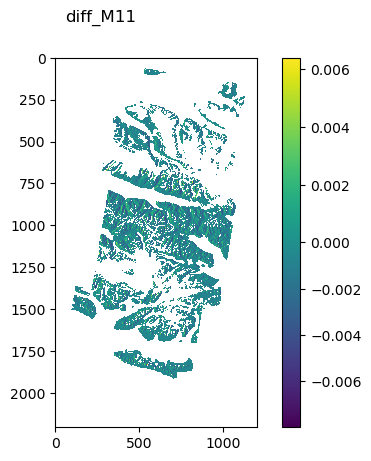

In [17]:
from matplotlib import colors

validate_M11 = validate_ds.M11.values
validate_M12 = validate_ds.M12.values

M11 = corrected_ds.M11.values
M12 = corrected_ds.M12.values

diff_M11 = M11 - validate_M11
diff_M12 = M12 - validate_M12

diff_min = np.ma.masked_invalid(diff_M11).min()
diff_max = np.ma.masked_invalid(diff_M11).max()
diff_min, diff_max
norm = colors.TwoSlopeNorm(vmin=diff_min, vcenter=0, vmax=diff_max)

_ = plt.imshow(diff_M11, interpolation='none', norm=norm)
_ = plt.colorbar(orientation='vertical')
_ = plt.suptitle('diff_M11')
_ = plt.show()

(-0.011362748, 0.0019763014)

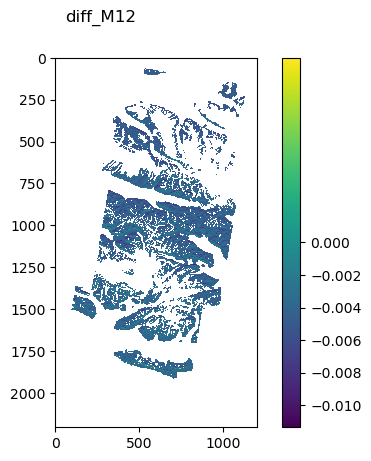

In [18]:
diff_min = np.ma.masked_invalid(diff_M12).min()
diff_max = np.ma.masked_invalid(diff_M12).max()
diff_min, diff_max
norm = colors.TwoSlopeNorm(vmin=diff_min, vcenter=0, vmax=diff_max)

_ = plt.imshow(diff_M12, interpolation='none', norm=norm)
_ = plt.colorbar(orientation='vertical')
_ = plt.suptitle('diff_M12')
_ = plt.show()

### Validate V* values

In [19]:
validate_va = validate_ds.va.values
validate_vx = validate_ds.vx.values
validate_vy = validate_ds.vy.values

corrected_va = corrected_ds.va.values
corrected_vx = corrected_ds.vx.values
corrected_vy = corrected_ds.vy.values

### Compare VA

(-37.0, 40.0)

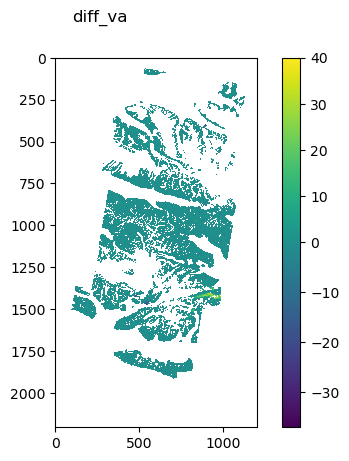

In [20]:
diff_va = validate_va - corrected_va
diff_min = np.ma.masked_invalid(diff_va).min()
diff_max = np.ma.masked_invalid(diff_va).max()
diff_min, diff_max
norm = colors.TwoSlopeNorm(vmin=diff_min, vcenter=0, vmax=diff_max)

_ = plt.imshow(diff_va, interpolation='none', norm=norm)
_ = plt.colorbar(orientation='vertical')
_ = plt.suptitle('diff_va')
_ = plt.show()

### Compare VX

(-4.0, 4.0)

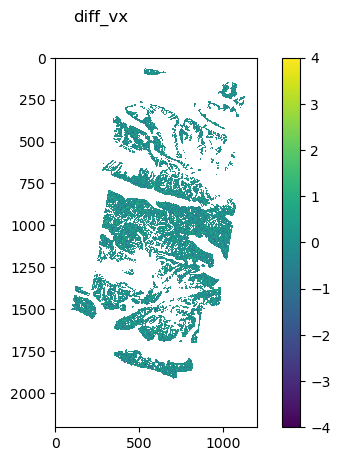

In [21]:
diff_vx = validate_vx - corrected_vx
diff_min = np.ma.masked_invalid(diff_vx).min()
diff_max = np.ma.masked_invalid(diff_vx).max()
diff_min, diff_max
norm = colors.TwoSlopeNorm(vmin=diff_min, vcenter=0, vmax=diff_max)

_ = plt.imshow(diff_vx, interpolation='none', norm=norm)
_ = plt.colorbar(orientation='vertical')
_ = plt.suptitle('diff_vx')
_ = plt.show()

### Compare VY

(-21.0, 21.0)

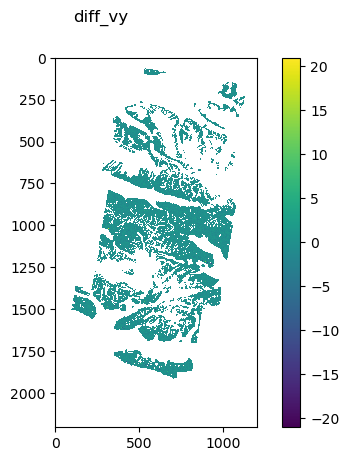

In [22]:
diff_vy = validate_vy - corrected_vy
diff_min = np.ma.masked_invalid(diff_vy).min()
diff_max = np.ma.masked_invalid(diff_vy).max()
diff_min, diff_max
norm = colors.TwoSlopeNorm(vmin=diff_min, vcenter=0, vmax=diff_max)

_ = plt.imshow(diff_vy, interpolation='none', norm=norm)
_ = plt.colorbar(orientation='vertical')
_ = plt.suptitle('diff_vy')
_ = plt.show()

### Plot original vx

In [23]:
corrected_ds.vx.encoding

{'zlib': True,
 'szip': False,
 'zstd': False,
 'bzip2': False,
 'blosc': False,
 'shuffle': True,
 'complevel': 2,
 'fletcher32': False,
 'contiguous': False,
 'chunksizes': (512, 1204),
 'source': '/Users/mliukis/Documents/ITS_LIVE/source/github-mliukis/itslive/src/dev_notebooks/corrected_S1_for_validation/S1A_IW_SLC__1SDH_20170710T154532_20170710T154559_017411_01D160_D5EE_X_S1B_IW_SLC__1SDH_20170716T154439_20170716T154506_006515_00B749_AC95_G0120V02_P046.nc',
 'original_shape': (2205, 1204),
 'dtype': dtype('int16'),
 '_FillValue': -32767}

In [25]:
corrected_ds

<xarray.Dataset>
Dimensions:           (x: 1204, y: 2205)
Coordinates:
  * x                 (x) float64 9.561e+05 9.562e+05 ... 1.1e+06 1.1e+06
  * y                 (y) float64 -4.712e+05 -4.713e+05 ... -7.357e+05
Data variables: (12/13)
    img_pair_info     <U1 ''
    mapping           <U1 ''
    vx                (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    vy                (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    v                 (y, x) float32 ...
    v_error           (y, x) float32 ...
    ...                ...
    va                (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    M11               (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    M12               (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    chip_size_width   (y, x) float32 ...
    chip_size_height  (y, x) float32 ...
    interp_mask       (y, x) float32 ...
Attributes: (12/15)
    GDAL_AREA_OR_POINT:         Area
    Conventions:                CF-1.8
    date_created:               05-Jun-2023 22:07:41
    title:                      autoRIFT surface velocities
    autoRIFT_software_version:  1.5.0
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    ...                         ...
    motion_coordinates:         radar, map
    author:                     Alex S. Gardner, JPL/NASA; Yang Lei, GPS/Caltech
    institution:                NASA Jet Propulsion Laboratory (JPL), Califor...
    source:                     NASA MEaSUREs ITS_LIVE project. Processed by ...
    references:                 When using this data, please acknowledge the ...
    date_updated:               21-Jun-2023 11:54:01

In [62]:
raise RuntimeError('Done')

RuntimeError: Done